In [1]:
#!pip install gensim
!pip install contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize, word_tokenize
from bs4 import BeautifulSoup 
from gensim.models import Word2Vec,KeyedVectors,word2vec
from gensim.test.utils import common_texts
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import contractions
import gensim
import nltk
import re

     |████████████████████████████████| 321 kB 17.3 MB/s 
     |████████████████████████████████| 284 kB 48.0 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=b60abce19b65f8e72724f972f296c6791cad5e7ba8833c5511a2b5a90e08e7fd
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
train_df = pd.read_csv("/content/Train_Data.csv")
test_df = pd.read_csv('/content/Test_Data.csv')

In [3]:
train_df.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers,average_review_rating
0,7f890f73298badd692c39c3801ef1d28,Batman - Role Play - Cowl and Batarang,Mattel,£14.99,NaN,4,1.0,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,"When kids aspire to be like Batman, it's easy ...",Technical Details Item Weight113 g Product Dim...,"When kids aspire to be like Batman, it's easy ...",http://www.amazon.co.uk/Rubies-Costume-Co-Flas...,NaN,Item was broken // 3.0 // 2 April 2014 // By\n...,"{""seller""=>{""Seller_name_1""=>""a1 Toys"", ""Selle...",4.5
1,83e55a2edb6c13dfc1c46d1577321b2e,Doctor Who 12-inch 50th Anniversary Collector ...,Dr Who,NaN,3 new,73,NaN,Figures & Playsets > Science Fiction & Fantasy,http://www.amazon.co.uk/Doctor-Who-Classic-Dal...,Product Description This ultimate Doctor Who c...,Technical Details Item Weight1.4 Kg Product Di...,Product Description This ultimate Doctor Who c...,http://www.amazon.co.uk/Dr-Who-Dalek-Projectio...,NaN,A wonderful collectors piece // 5.0 // 31 Aug....,NaN,4.6
2,4bfaaf6558582a0f337ad59fcd51fcf7,Melissa & Doug Sticker Collection - Pink,Melissa & Doug,£4.76,15 new,47,1.0,Arts & Crafts > Paper & Stickers,http://www.amazon.co.uk/Melissa-Doug-Sticker-C...,"Product Description Cute couture, adorable ani...",Technical Details Item Weight299 g Product Dim...,"Product Description Cute couture, adorable ani...",http://www.amazon.co.uk/Melissa-Doug-Habitats-...,NaN,Great sticker collection // 5.0 // 19 Jun. 201...,NaN,4.7
3,4e6702cb7fe9278f16dedc39a8808c72,"Rock and Roll Cards, 30 Team",ClubKing Ltd,£4.49,2 new,2,1.0,Hobbies > Trading Cards & Accessories > Packs ...,http://www.amazon.co.uk/ClubKing-Ltd-Football-...,"1 Pack of 25 Football Cards, 30 rockstars on e...",Technical Details Item Weight100 g Product Dim...,"1 Pack of 25 Football Cards, 30 rockstars on e...",http://www.amazon.co.uk/ClubKing-Ltd-Football-...,how many cards in a pack it dosn't say..?? // ...,Rock and roll cards // 5.0 // 28 July 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""ClubKing Ltd"", ...",5.0
4,f505611d18b0ae98258896ae1b0f14c8,Crayola 16 Pipsqueak Glitter Glues,Crayola,£5.99,9 new,10,1.0,Characters & Brands > Crayola,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,Product Description 16 Pipsqueak washable glit...,Technical Details Item Weight186 g Product Dim...,Product Description 16 Pipsqueak washable glit...,http://www.amazon.co.uk/Crayola-3-3542-9-Glitt...,NaN,Little fingers big imagination // 5.0 // 4 Mar...,"{""seller""=>[{""Seller_name_1""=>""BIC WAREHOUSE"",...",4.2


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      7486 non-null   object 
 1   product_name                                 7486 non-null   object 
 2   manufacturer                                 7481 non-null   object 
 3   price                                        6417 non-null   object 
 4   number_available_in_stock                    5587 non-null   object 
 5   number_of_reviews                            7486 non-null   object 
 6   number_of_answered_questions                 6909 non-null   float64
 7   amazon_category_and_sub_category             7000 non-null   object 
 8   customers_who_bought_this_item_also_bought   6665 non-null   object 
 9   description                                  7013 non-null   object 
 10  

Text(0, 0.5, 'Count')

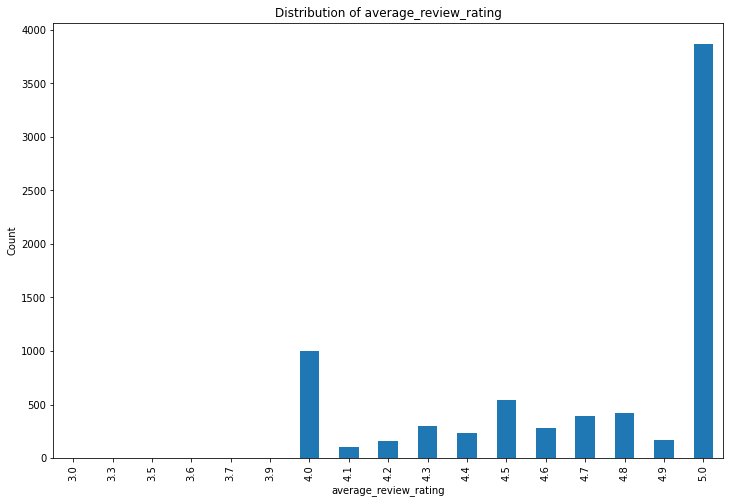

In [5]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
train_df['average_review_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of average_review_rating')
plt.xlabel('average_review_rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 50 products')

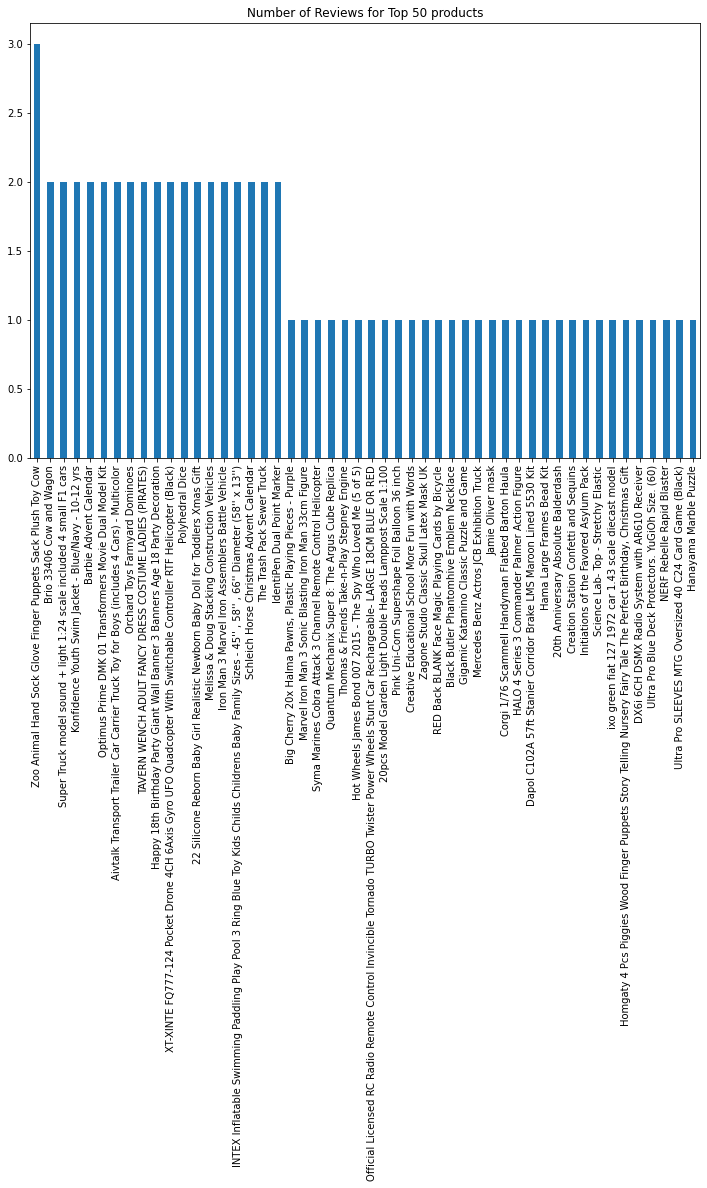

In [6]:
# Plot number of reviews for top 50 products
products = train_df["product_name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 products")

Text(0.5, 1.0, 'Number of Reviews for Top 50 manufacturers')

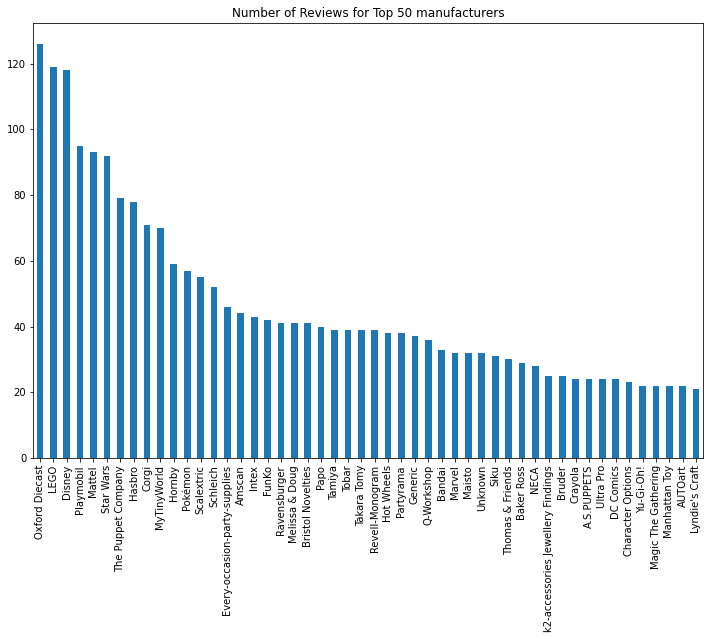

In [7]:
# Plot number of reviews for top 50 manufacturers
brands = train_df['manufacturer'].value_counts()
plt.figure(figsize=(12,8))
brands[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 manufacturers")

Text(0, 0.5, 'Count')

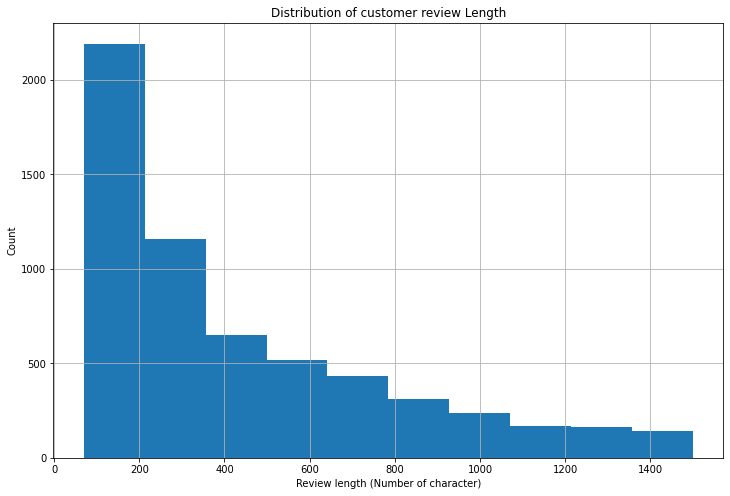

In [8]:
# Plot distribution of review length
review_length = train_df["customer_reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of customer review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [9]:
train_df.isnull().sum()

uniq_id                                           0
product_name                                      0
manufacturer                                      5
price                                          1069
number_available_in_stock                      1899
number_of_reviews                                 0
number_of_answered_questions                    577
amazon_category_and_sub_category                486
customers_who_bought_this_item_also_bought      821
description                                     473
product_information                              45
product_description                             473
items_customers_buy_after_viewing_this_item    2307
customer_questions_and_answers                 6817
customer_reviews                                  3
sellers                                        2314
average_review_rating                             0
dtype: int64

In [10]:
train_df.shape

(7486, 17)

In [11]:
train_df.dropna(inplace=True)

In [12]:
# Drop missing values
train_df['customer_reviews']

3       Rock and roll cards // 5.0 // 28 July 2013 // ...
14      great set when you work out the value // 5.0 /...
39      Her most favorite birthday present! // 5.0 // ...
48      Great toy for girls // 5.0 // 8 Feb. 2016 // B...
54      Good fun // 5.0 // 27 July 2014 // By\n    \n ...
                              ...                        
7395    Outrageously good value. // 5.0 // 8 Dec. 2012...
7397    Beautiful cards // 5.0 // 26 Nov. 2013 // By\n...
7403    Cars cars cars // 5.0 // 8 Jan. 2016 // By\n  ...
7447    An excellent set // 5.0 // 16 Jun. 2013 // By\...
7480    Pinwheel Magic! // 4.0 // 26 Jun. 2013 // By\n...
Name: customer_reviews, Length: 389, dtype: object

In [13]:
train_df['customer_reviews'].isnull().sum()

0

In [14]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [15]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(train_df['customer_reviews'],train_df['average_review_rating'],test_size=0.2, random_state=42)

In [16]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])

for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 party eye masks may by cinderella on may fantastic value for money quick delivery bought two packs for my sons upcoming batman superhero party i m sure they will go down a treat good value eye masks april by e boulton on april quick delivery and good value comfortable to wear very pretty colours added some bows and sparkly bits and gave them to our friends he and all the kids loved them as well as some of the adults i jun by lana on jun bought for my nephews th birthday party which was a superhero theme he and all the kids loved them as well as some of the adults i would definitely recommend these the price was great and delivery was fast not impressed jun by lp on jun not sure what happened to my pack one mask had the elastic snapped in two already so it wasn t wearable and the other ones look like they are going to rip really easily a bit diss appointed ok quality nov by m powell on nov ok quality good price used for a children s superher

In [17]:
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])

Number of features : 8375 

Show some feature names : 
 ['aa', 'campbell', 'discount', 'german', 'kery', 'noisy', 'refunded', 'status', 'vzzcywm']


In [18]:
lb=preprocessing.LabelEncoder()

In [19]:
y_train_encoded=lb.fit_transform(y_train)

In [20]:
y_train_encoded

array([11, 11,  8,  9, 11, 11,  9, 10,  6,  4,  4, 10, 11,  5, 11,  2,  1,
        8,  2,  8,  8,  5,  7, 11,  8,  1, 11,  8,  4,  9,  6, 11,  8,  1,
       10,  5,  4,  9,  1,  5,  7,  3,  7,  2,  2,  7, 10,  7,  8,  6,  4,
        1, 10,  7,  0, 11,  3, 11,  7,  6,  6,  6,  9,  1, 11, 11,  3,  9,
        7,  6,  9,  9,  9,  8, 11, 11,  1, 11,  8, 11,  4,  8,  3,  2, 10,
        5, 11,  8, 11,  1, 10, 11, 11,  7, 11,  8,  5,  7,  7,  7,  7,  9,
        8,  1,  9, 11,  4,  1,  6,  4,  1,  5,  8, 10,  4,  1, 11,  5,  9,
       11, 11,  5, 11,  6,  6, 11,  2, 11,  7, 11,  2,  6, 11,  6,  4,  4,
        9,  8,  2,  6,  7,  6,  6,  2, 10,  7, 10, 10, 11,  8,  8, 11, 10,
       10,  2,  1, 11, 10, 11,  4,  6,  4,  7,  9,  3,  8, 11,  7,  7,  6,
        3, 10,  9,  1,  8, 11, 11, 11,  2, 11,  9,  8,  1,  7,  5,  8,  6,
        5,  8,  8,  3, 11, 11, 10, 11, 11, 10,  6,  3, 11,  1, 11,  4, 11,
        1,  7,  1,  1, 11,  9,  1, 10,  4,  6,  7,  6,  8,  6,  3,  1, 10,
       11,  1,  4, 10, 10

In [21]:
y_test

4858    4.3
804     4.7
3073    3.5
747     4.8
6618    4.7
       ... 
48      5.0
282     4.7
1733    4.5
1973    4.0
4545    5.0
Name: average_review_rating, Length: 78, dtype: float64

In [22]:
y_test_encoded = lb.fit_transform(y_test)

In [23]:
y_test_encoded

array([ 4,  8,  0,  9,  8,  8,  4,  8,  5,  0, 11,  5, 10,  6,  3,  6, 11,
        4, 11, 11,  7,  4,  3,  9, 11, 11,  7,  1, 10, 11, 11,  5, 11,  3,
        6,  6, 10,  2,  4, 10,  9,  9,  9,  7, 11, 11, 10, 11,  2,  6,  4,
       11,  1, 11, 11,  4, 11, 11, 11,  3, 11, 11,  3,  9,  9,  3,  4,  9,
        9,  6, 11, 11,  5, 11,  8,  6,  1, 11])

In [24]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train_encoded)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
predictions = mnb.predict(countVect.transform(X_test_cleaned))

In [26]:
predictions

array([ 7,  7,  8,  8,  8,  7,  8,  7,  7,  7,  9,  7,  7,  7,  4,  7,  8,
        7, 11,  8,  7,  7,  7,  7, 11,  8,  7,  8,  7, 11,  7,  8,  8,  8,
        7, 11,  7,  7,  7,  7,  8,  7,  7,  7,  7, 11,  8, 11,  9,  7,  7,
        6,  8, 11,  7,  4,  7,  7,  7,  7,  7,  7,  6,  4,  4,  7,  7,  7,
        7,  7, 11,  7,  7,  8,  8,  4,  7,  6])

In [27]:
prediction =lb.inverse_transform(predictions )

In [28]:
prediction

array([4.6, 4.6, 4.7, 4.7, 4.7, 4.6, 4.7, 4.6, 4.6, 4.6, 4.8, 4.6, 4.6,
       4.6, 4.3, 4.6, 4.7, 4.6, 5. , 4.7, 4.6, 4.6, 4.6, 4.6, 5. , 4.7,
       4.6, 4.7, 4.6, 5. , 4.6, 4.7, 4.7, 4.7, 4.6, 5. , 4.6, 4.6, 4.6,
       4.6, 4.7, 4.6, 4.6, 4.6, 4.6, 5. , 4.7, 5. , 4.8, 4.6, 4.6, 4.5,
       4.7, 5. , 4.6, 4.3, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.5, 4.3, 4.3,
       4.6, 4.6, 4.6, 4.6, 4.6, 5. , 4.6, 4.6, 4.7, 4.7, 4.3, 4.6, 4.5])

In [29]:
def modelEvaluation(y_tst,pred):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(np.sqrt(mean_squared_error(y_tst, pred))))

In [30]:
modelEvaluation(lb.inverse_transform(y_test_encoded),predictions)


Accuracy on validation set: 3.1841


In [31]:
test_df.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,90093bd02c6d5ce6d6c8f2e2af411fc1,Dolls House Miniature Cats x2,Heidi Ott,£12.00,NaN,1,1.0,Dolls & Accessories > Dolls' House Dolls & Acc...,NaN,A pair of dolls house miniature cats. This 1/1...,Technical Details Item Weight5 g Product Dimen...,A pair of dolls house miniature cats. This 1/1...,NaN,NaN,Dolls house miniatures // 5.0 // 9 Jan. 2013 /...,"{""seller""=>{""Seller_name_1""=>""1 12 Dollshouses..."
1,8dec13104fd4d1ad3ad5d9ff2af9ca0b,Disney Princess T7561 Tangled Rapunzel's Gondo...,Disney Princess,NaN,5 new,15,4.0,Characters & Brands > Disney > Toys,http://www.amazon.co.uk/Disney-Princess-Y0942-...,Product Description Relive the romantic moment...,Technical Details Item Weight907 g Product Dim...,Product Description Relive the romantic moment...,http://www.amazon.co.uk/Disney-Princess-Y0942-...,NaN,Tangled // 4.0 // 16 May 2011 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Anita Mall"", ""S..."
2,0fcde78856668c1563f54650b17620e7,My Pirate Party Music CD,Unknown,£4.99,1 used,6,1.0,Figures & Playsets > Pirates,http://www.amazon.co.uk/Pirate-Pencils-Childre...,Set the atmosphere for your Pirate themed part...,Technical Details Manufacturer recommended age...,Set the atmosphere for your Pirate themed part...,http://www.amazon.co.uk/Jake-And-The-Neverland...,NaN,Okay but that's all // 1.0 // 11 July 2011 // ...,"{""seller""=>{""Seller_name_1""=>""BuzzBase"", ""Sell..."
3,69a9becbd60381a4eb7cdafe30761ee4,1ST BIRTHDAY BANNER GIRL (BGC HOLOGRAPHIC) 9FT...,Every-occasion-party-supplies,£1.49,5 new,22,1.0,"Party Supplies > Banners, Stickers & Confetti ...",http://www.amazon.co.uk/1ST-BIRTHDAY-GIRL-PINK...,12ft long,Technical Details Manufacturer recommended age...,12ft long,http://www.amazon.co.uk/12ft-Foil-Ladybird-Bir...,NaN,Good quality but take down carefully as the fo...,NaN
4,18bc8b988f43f352b946a253642e1c6e,Beavis and Butt-Head Great Cornholio Bobble Head,Beavis And Butt-Head,£84.43,NaN,1,1.0,Hobbies > Collectible Figures & Memorabilia > ...,NaN,From the Beavis and Butt-Head TV series comes ...,Technical Details Item Weight159 g Product Dim...,From the Beavis and Butt-Head TV series comes ...,NaN,NaN,hilarious // 5.0 // 11 Dec. 2013 // By\n \n...,"{""seller""=>{""Seller_name_1""=>""M and N Media US..."


In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      2496 non-null   object 
 1   product_name                                 2496 non-null   object 
 2   manufacturer                                 2494 non-null   object 
 3   price                                        2133 non-null   object 
 4   number_available_in_stock                    1898 non-null   object 
 5   number_of_reviews                            2496 non-null   int64  
 6   number_of_answered_questions                 2309 non-null   float64
 7   amazon_category_and_sub_category             2298 non-null   object 
 8   customers_who_bought_this_item_also_bought   2255 non-null   object 
 9   description                                  2322 non-null   object 
 10  

In [33]:
test_df.customer_reviews.isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
2491    False
2492    False
2493    False
2494    False
2495    False
Name: customer_reviews, Length: 2496, dtype: bool

In [34]:
# Preprocess text data in training set and validation set

test_df_cleaned = []

for d in test_df['customer_reviews']:
    test_df_cleaned .append(cleanText(d))
print('Show a cleaned review in the training set : \n',  test_df_cleaned [10])

Show a cleaned review in the training set : 
 so life like may by shoemaker vine voice on may very well painted and durable and so life like luke and ben just love these papo toys are of a very high quality i would recommend to anyone but were did he leave his horse it is on here can be used together with the papo horse if you like oct by bay on oct beautiful figure it is made to be mounted on the papo horse so if you choose to have the figure without the horse as i did then it comes up a little shorter than for instance the papo queen figure that we bought to go with him great toy jan by louise fenwick on jan delivery was good the product is lovely and sturdy and has a lot of detail my four year old boy loves it and i m very pleased just the job dec by amazon customer on dec whilst at hampton court my son purchased with pocket money a horse by papo and loved it so much that i decided to get him the rider a sneaky look at amazon to compare prices revealed a cheaper price hence i ordere

In [35]:
predictions_test_df = mnb.predict(countVect.transform(test_df_cleaned ))

In [36]:
predictions_test_df

array([ 9,  7,  7, ..., 11,  9,  6])

In [37]:
predictions_test = lb.inverse_transform(predictions_test_df)

In [38]:
predictions_test

array([4.8, 4.6, 4.6, ..., 5. , 4.8, 4.5])

In [39]:
predictions_test = pd.DataFrame(predictions_test)

In [40]:
predictions_test 

,0
0,4.8
1,4.6
2,4.6
3,4.7
4,4.7
...,...
2491,4.6
2492,4.6
2493,5.0
2494,4.8


In [41]:
predictions_test.index = pd.DataFrame(predictions_test).index

In [42]:
predictions_test.columns = ["prediction"]

In [43]:
predictions_test.to_csv("submission.csv", index = False) 